In this notebook, we apply an untargeted kernel-based attack to a simple generator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tapas.datasets
import tapas.generators
import tapas.threat_models
import tapas.attacks

import tqdm

In [2]:
np.random.seed(13121)

## Real-world private datasets

The COLLAB dataset contains collaboration networks of academics. They are ego networks for these academics.

In [3]:
data = tapas.datasets.TUDataset.read("deezer_ego_nets", "deezer_ego_nets")

Loading TU graph dataset: deezer_ego_nets


## Kernel

In [4]:
import networkx as nx
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [5]:
from grakel import WeisfeilerLehman, VertexHistogram

# TODO: find a better kernel -- vertex histogram is silly here, since there is very little (no?) overlap.
# We address this by relabelling nodes to 1..num_nodes.
kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

## Threat modelling (reusing some tools from TAPAS, but mostly custom)

In [6]:
import pandas as pd
from scipy.stats import beta, expon

In [7]:
class BAGeneratorSafe(tapas.generators.Generator):
    
    def fit(self, dataset):
        self.description = dataset.description
        all_n = [len(G.nodes) for G in dataset.data]
        self._exp_params = expon.fit(all_n)
        all_nedges = [len(G.edges) for G in dataset.data]
        all_densities = [ne / (n*(n-1)/2) for n, ne in zip(all_n, all_nedges)]
        self._beta_params = beta.fit(all_densities)

    def generate(self, num_samples, random_state=None):
        graph_sizes = expon.rvs(*self._exp_params, size=num_samples).astype(int)
        densities = beta.rvs(*self._beta_params, size=num_samples)
        m_param = [min(n-1, max(1, int(np.round(d*(n-1)*2)))) for n, d in zip(graph_sizes, densities)]
        graphs = [nx.barabasi_albert_graph(n, m) for n, m in zip(graph_sizes, m_param)]
        return tapas.datasets.TUDataset(pd.Series(graphs), self.description)

    @property
    def label(self):
        return "Barabasi-Albert Generator"

In [8]:
class BAGeneratorNaive(tapas.generators.Generator):
    def fit(self, dataset):
        self.description = dataset.description
        self.all_n = [len(G.nodes) for G in dataset.data]
        self.all_m = [max(1, int(np.round(len(G.edges)/len(G.nodes)))) for G in dataset.data]

    def generate(self, num_samples, random_state=None):
        indices = np.random.choice(len(self.all_n), size=(num_samples,))
        graphs = [nx.barabasi_albert_graph(self.all_n[i], self.all_m[i]) for i in indices]
        return tapas.datasets.TUDataset(pd.Series(graphs), self.description)

    @property
    def label(self):
        return "Barabasi-Albert Generator"

In [9]:
generator = BAGeneratorNaive()
# generator = BAGenerator()
# generator = tapas.generators.Raw()

We will generate datasets etc. in a custom way (not TAPAS at this point).

In [10]:
size_private_dataset = 100
size_synthetic_dataset = 100
train_test_split = 0.5

We do a train/test split.

In [11]:
# train_data = data

# test_data = train_data.create_subsets(
#     n=1,
#     sample_size=int(train_test_split*len(data)),
#     drop_records=True
# )[0]

In [12]:
# We select a small number of users, to make the problem slightly easier and enable the
#  decomposition of ROC curves per target user.
train_data, test_data = data.create_subsets(n=2, sample_size=200)

Generate (1) real datasets of size 100, $(D^r_i)_{i\in\mathbb{N}}$, (2) "real" datasets with no overlap in records of the same size, $(D^d_i)_{i\in\mathbb{N}}$, and (3) synthetic datasets from the real datasets, $(D^s_i)_{i\in\mathbb{N}}$. These will then be used as training set for the classifier.

In [13]:
def get_samples(full_dataset, num_samples):
    real = []
    synth = []
    disjoint = []
    for _ in tqdm.trange(num_samples):
        r, d = full_dataset.create_subsets(2, sample_size=size_private_dataset, drop_records=False)
        real.append(r)
        disjoint.append(d)
        synth.append(generator(r, size_synthetic_dataset))
    return real, disjoint, synth

In [14]:
num_samples = 200

In [15]:
train_samples = get_samples(train_data, num_samples=num_samples)

100%|██████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.60it/s]


In [16]:
holdout_samples = get_samples(train_data, num_samples=num_samples)

100%|██████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.54it/s]


In [17]:
test_samples = get_samples(test_data, num_samples=num_samples)

100%|██████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.50it/s]


##  Feature extraction

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [19]:
def extract_kernel_features(samples):
    # Compute the graph kernel between synthetic data and individual records
    X = []
    y = []
    for positive, negative, synth in tqdm.tqdm(zip(*samples), total=len(samples[0])):
        # The features we are going to compute are k(synth_dataset, record).
        # We first "fit" the kernel (s.t. kernel.transform:  g -> k(synth_dataset, g)).
        kernel.fit(_grak(synth.data))
        # Then apply it to positive and negative records.
        for record in positive + negative:
            X.append(kernel.transform(_grak(record.data))[0])
        y += [True] * len(positive)
        y += [False] * len(negative)
    return np.array(X), np.array(y)

In [20]:
X_train, y_train = extract_kernel_features(train_samples)

100%|██████████████████████████████████████████████████████| 200/200 [10:29<00:00,  3.15s/it]


In [21]:
X_holdout, y_holdout = extract_kernel_features(holdout_samples)

100%|██████████████████████████████████████████████████████| 200/200 [07:07<00:00,  2.14s/it]


In [22]:
X_test, y_test = extract_kernel_features(test_samples)

100%|██████████████████████████████████████████████████████| 200/200 [04:35<00:00,  1.38s/it]


In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
# model = LogisticRegression()
model = RandomForestClassifier(n_estimators=1000)
# model = RandomForestClassifier(max_depth=2)
# model = MLPClassifier(hidden_layer_sizes=[200, 200, 200, 200])
# model = GradientBoostingClassifier()

In [25]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [26]:
train_scores = model.predict_proba(X_train)[:,1]

In [27]:
holdout_scores = model.predict_proba(X_holdout)[:,1]

In [28]:
test_scores = model.predict_proba(X_test)[:,1]

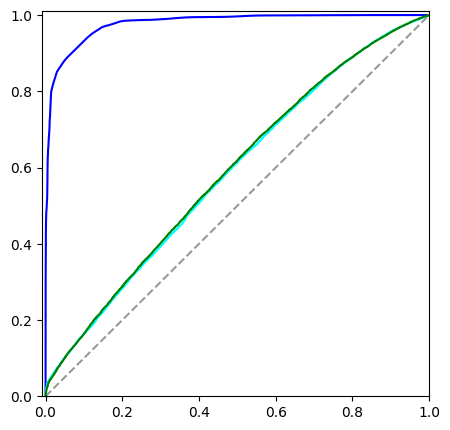

In [29]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], 'k--', alpha=.4)

# Training accuracy!
tpr, fpr, _ = roc_curve(y_train, train_scores)
plt.plot(tpr, fpr, 'b')

# Holdout -- evaluation on new samples from the same set.
tpr, fpr, _ = roc_curve(y_holdout, holdout_scores)
plt.plot(tpr, fpr, color=(0,1,1))

# Test accuracy on a disjoint set.
tpr, fpr, _ = roc_curve(y_test, test_scores)
plt.plot(tpr, fpr, 'g')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

### Disaggregate by target

Is it the case that ROC curves for individual users are better than the average ROC curve?

In [30]:
from collections import defaultdict

In [31]:
record_map_train = defaultdict(set)

idx = 0
for positive, negative, synth in zip(*train_samples):
    for record in positive + negative:
        record_map_train[record.data.iloc[0]].add(idx)
        idx += 1

In [32]:
record_map_holdout = defaultdict(set)

idx = 0
for positive, negative, synth in zip(*holdout_samples):
    for record in positive + negative:
        record_map_holdout[record.data.iloc[0]].add(idx)
        idx += 1

In [33]:
record_map_test = defaultdict(set)

idx = 0
for positive, negative, synth in zip(*test_samples):
    for record in positive + negative:
        record_map_test[record.data.iloc[0]].add(idx)
        idx += 1

Select users with enough counts.

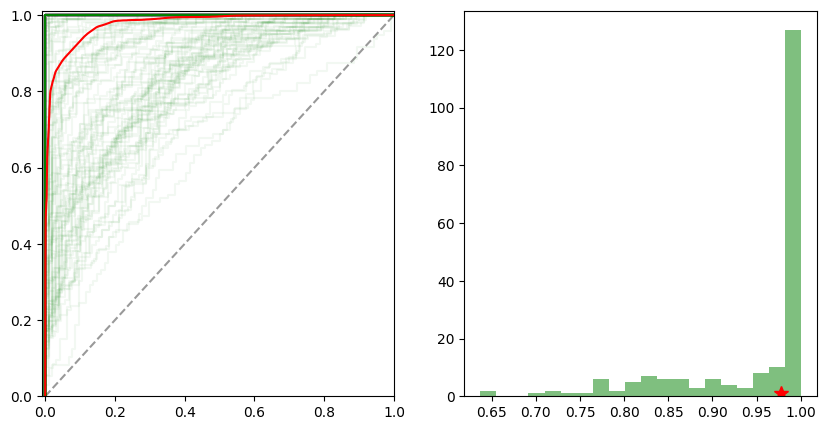

In [35]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot([0,1], [0,1], 'k--', alpha=.4)

aucs_train = []

for indices in record_map_train.values():
    if len(indices) >= 10:
        scores = train_scores[np.array(list(indices))]
        labels = y_train[np.array(list(indices))]
        tpr, fpr, _ = roc_curve(labels, scores)
        plt.plot(tpr, fpr, 'g', alpha=.05)
        aucs_train.append(roc_auc_score(labels, scores))

# Training accuracy!
tpr, fpr, _ = roc_curve(y_train, train_scores)
plt.plot(tpr, fpr, 'r')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

plt.subplot(1, 2, 2)
plt.plot([roc_auc_score(y_train, train_scores)], [1], 'r*', ms=10)
plt.hist(aucs_train, 20, facecolor='g', alpha=.5);

In [36]:
roc_auc_score(y_train, train_scores)

0.97822312375

In [37]:
np.mean(aucs_train)

0.9507721675623481

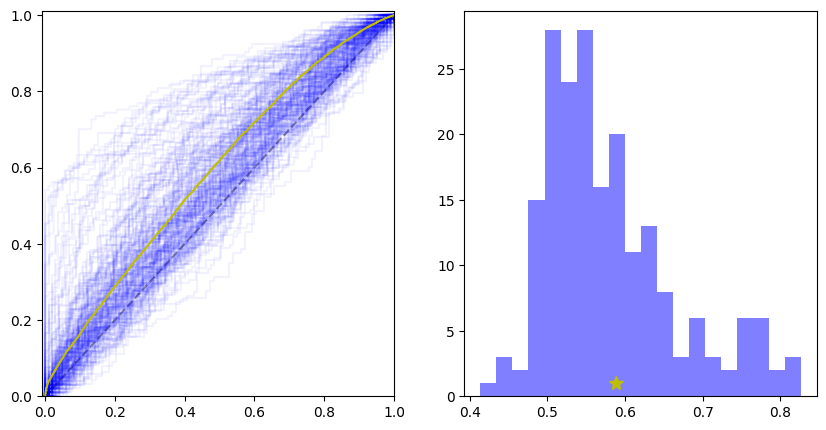

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot([0,1], [0,1], 'k--', alpha=.4)

aucs_test = []

for indices in record_map_test.values():
    if len(indices) >= 10:
        scores = test_scores[np.array(list(indices))]
        labels = y_test[np.array(list(indices))]
        tpr, fpr, _ = roc_curve(labels, scores)
        plt.plot(tpr, fpr, 'b', alpha=.05)
        aucs_test.append(roc_auc_score(labels, scores))

# Training accuracy!
tpr, fpr, _ = roc_curve(y_test, test_scores)
plt.plot(tpr, fpr, 'y')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);


plt.subplot(1, 2, 2)
plt.plot([roc_auc_score(y_test, test_scores)], [1], 'y*', ms=10)
plt.hist(aucs_test, 20, facecolor='b', alpha=.5);

In [39]:
roc_auc_score(y_test, test_scores)

0.5886347675

In [40]:
np.mean(aucs_test)

0.5815517357866481

#### Is there a link between AUC on the train set and the holdout/test set? (no)

In [41]:
auc_per_user_train = {}

for user, indices in record_map_train.items():
    scores = train_scores[np.array(list(indices))]
    labels = y_train[np.array(list(indices))]
    auc_per_user_train[user] = roc_auc_score(labels, scores)

In [42]:
auc_per_user_holdout = {}

for user, indices in record_map_holdout.items():
    scores = train_scores[np.array(list(indices))]
    labels = y_train[np.array(list(indices))]
    auc_per_user_holdout[user] = roc_auc_score(labels, scores)

In [43]:
_x_auc = []
_y_auc = []

for user in auc_per_user_train:
    if user in auc_per_user_holdout:
        _x_auc.append(auc_per_user_train[user])
        _y_auc.append(auc_per_user_holdout[user])

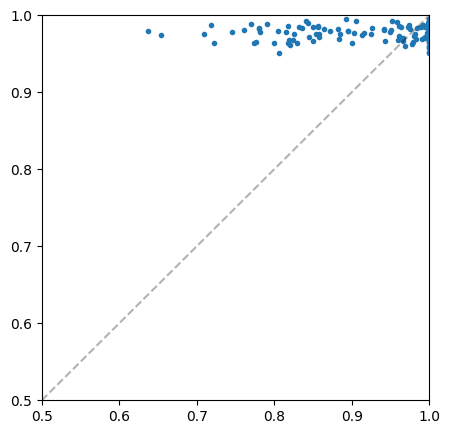

In [44]:
plt.figure(figsize=(5,5))
plt.plot(_x_auc, _y_auc, '.')
plt.plot([0.5, 1], [0.5, 1], 'k--', alpha=.3)
plt.xlim([0.5, 1])
plt.ylim([0.5, 1 ]);

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
m = LinearRegression()
m.fit(np.array(_x_auc).reshape(-1, 1), _y_auc);

In [47]:
m.intercept_

0.9671230764138483

In [48]:
m.coef_  # No effect.

array([0.01181741])

### Disaggregate by dataset

Is it the case that ROC curves for individual _datasets_ are better than the average ROC curve? (no!)

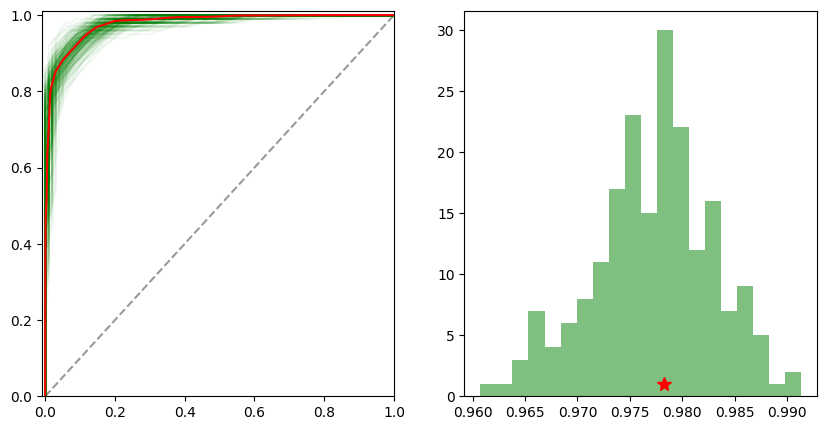

In [49]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot([0,1], [0,1], 'k--', alpha=.4)

aucs_train = []

for idx in range(num_samples):
    indices = np.arange(idx*2*size_private_dataset, (idx+1)*2*size_private_dataset)
    scores = train_scores[indices]
    labels = y_train[indices]
    tpr, fpr, _ = roc_curve(labels, scores)
    plt.plot(tpr, fpr, 'g', alpha=.05)
    aucs_train.append(roc_auc_score(labels, scores))


# Training accuracy!
tpr, fpr, _ = roc_curve(y_train, train_scores)
plt.plot(tpr, fpr, 'r')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

plt.subplot(1, 2, 2)
plt.plot([roc_auc_score(y_train, train_scores)], [1], 'r*', ms=10)
plt.hist(aucs_train, 20, facecolor='g', alpha=.5);

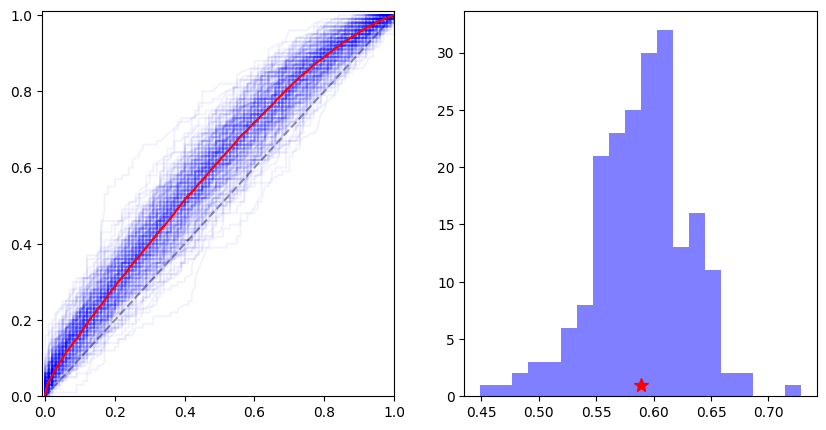

In [50]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot([0,1], [0,1], 'k--', alpha=.4)

aucs_test = []

for idx in range(num_samples):
    indices = np.arange(idx*2*size_private_dataset, (idx+1)*2*size_private_dataset)
    scores = test_scores[indices]
    labels = y_test[indices]
    tpr, fpr, _ = roc_curve(labels, scores)
    plt.plot(tpr, fpr, 'b', alpha=.05)
    aucs_test.append(roc_auc_score(labels, scores))


# Training accuracy!
tpr, fpr, _ = roc_curve(y_test, test_scores)
plt.plot(tpr, fpr, 'r')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

plt.subplot(1, 2, 2)
plt.plot([roc_auc_score(y_test, test_scores)], [1], 'r*', ms=10)
plt.hist(aucs_test, 20, facecolor='b', alpha=.5);